In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import gzip
import struct
from tqdm.notebook import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Use device: {device}")


Use device: cuda


## 1.Data Preprocessing and Augmentation

This section handles the loading and preprocessing of the Fashion-MNIST dataset. Key steps include:

- **Loading raw data** from the official `.gz` format;
- **Normalizing pixel values** to the range [0, 1];
- **Expanding the channel dimension** to match the input shape required by CNNs (`1x28x28`);
- **Converting to PyTorch tensors** for use with `DataLoader`;
- **Applying data augmentation** to the training set using:
  - Random small-angle rotations
  - Horizontal flips
  - Random resized crops
- **Standard normalization** (mean = 0, std = 1) is applied to both training and test sets.

We also provide a utility function `visualize_augmented_samples()` to visually inspect multiple augmented versions of a single input image, ensuring that the data augmentation process is working as intended.


In [3]:
# Class label names for Fashion-MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16)\
                    .reshape(len(labels), 28, 28)

    return images, labels

# Load and preprocess Fashion-MNIST data
data_dir = r'D:\vscode\1\CatDad\fashion-mnist\data'

train_images, train_labels = load_mnist(data_dir, kind='train')
test_images, test_labels = load_mnist(data_dir, kind='t10k')

# 1. Normalize to [0,1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# 2. Add channel dimension
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

# 3. Convert to tensors
X_train = torch.tensor(train_images)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_images)
y_test = torch.tensor(test_labels, dtype=torch.long)


train_transform = transforms.Compose([
    transforms.RandomRotation(15),              # Random small-angle rotation
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)), # Random cropping and resizing
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0, std 1
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# 4. Dataloader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Visualize training image with random augmentations
def visualize_augmented_samples(X_tensor, y_tensor, transform, class_names, indices=[0, 100, 200]):
    for idx in indices:
        img_tensor = X_tensor[idx]  # shape [1,28,28]
        label = y_tensor[idx].item()
        img_array = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_array)

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        for ax in axes:
            ax.axis('off')

        for i in range(4): # Show 4 different augmented versions
            augmented_img = transform(pil_img)
            axes[i].imshow(augmented_img.squeeze().numpy(), cmap='gray')
            axes[i].set_title(f'Aug {i+1}')

        fig.suptitle(f'Label: {class_names[label]} ({label})', fontsize=14)
        plt.tight_layout()
        plt.show()

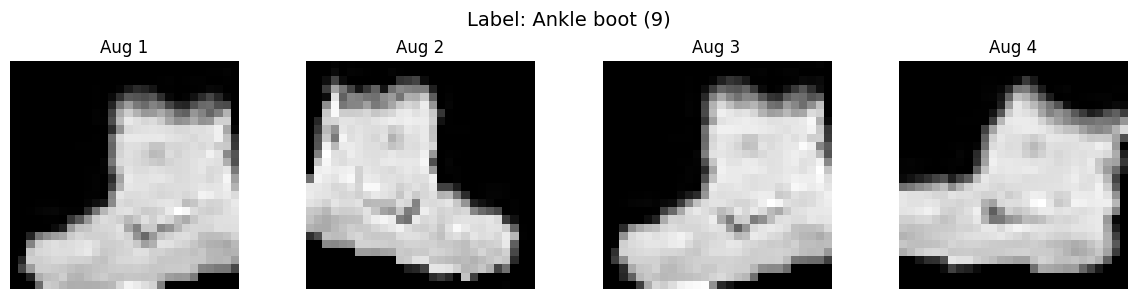

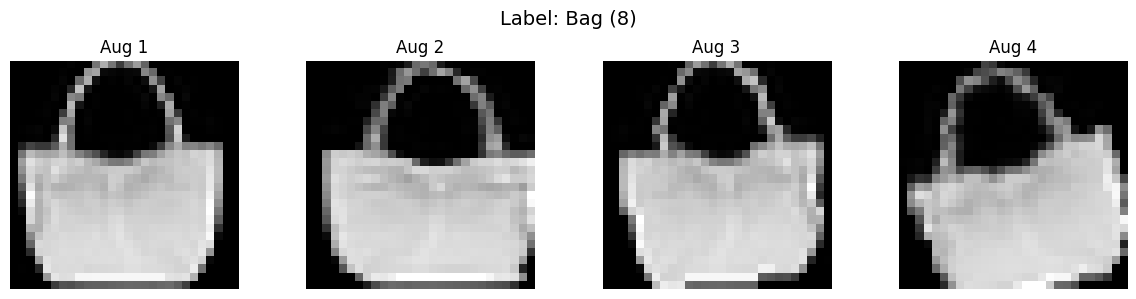

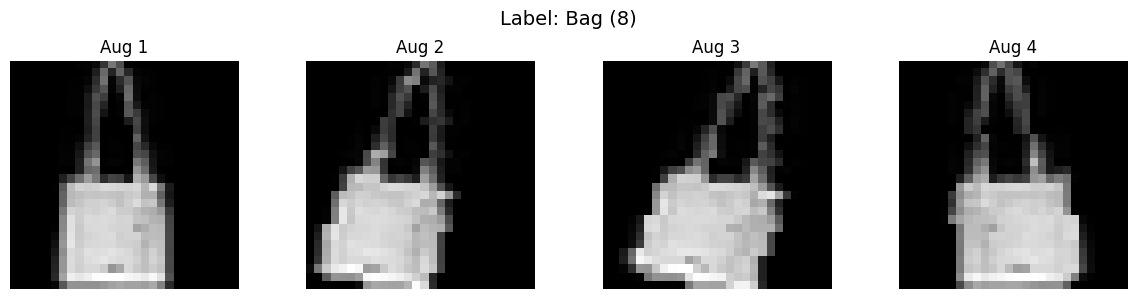

In [4]:
if __name__ == "__main__":
    visualize_augmented_samples(X_train, y_train, train_transform, class_names)


## 2.Forward Propagation: FashionCNN, Classifier with Optional SEBlock

This section introduces the **FashionCNN** model designed for Fashion-MNIST classification. The model follows a conventional convolutional neural network (CNN) structure and can optionally incorporate **Squeeze-and-Excitation (SE)** blocks for channel-wise attention enhancement.

---

### Model Components

####  (1). Convolutional Feature Extractor
The model includes 3 convolutional blocks. Each block consists of:

- `Conv2D` layer with padding=1 (to preserve spatial size)
- `BatchNorm2D` for normalization and stability
- `ReLU` activation
- `MaxPool2D (2×2)` to reduce spatial resolution
- `Dropout2D` for regularization

The output channels are progressively increased:  
**Input (1 channel) → 32 → 64 → 128**

####  (2). Fully Connected Classifier
After flattening the feature map, the network includes:

- `FC1`: Fully connected layer with 256 units + ReLU + Dropout
- `FC2`: Final output layer with 10 units (for 10 classes)

#### (3). SEBlock (Squeeze-and-Excitation)
The `SEBlock` applies global average pooling followed by a gating mechanism (MLP + sigmoid) to scale each channel's activation. This mechanism enhances the representation power by modeling **inter-channel dependencies**.

---

### Forward Propagation Flow

```text
Input Image (1×28×28)
        │
   ┌────▼─────┐
   │ Conv2D   │ → 32 channels
   └────▲─────┘
        │
    BatchNorm
        │
       ReLU
        │
     MaxPool2D
        │
     Dropout2D
        ↓
   ┌────Block────┐
   │  Repeat x3  │ (with increasing channels: 32→64→128)
   └─────────────┘
        ↓
     Flatten
        ↓
   Fully Connected (256) → Dropout
        ↓
   Output Layer (10 classes)


In [5]:
# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        # Global Average Pooling
        y = x.view(b, c, -1).mean(dim=2)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        # Channel-wise attention scaling
        return x * y


# CNN Architecture for Fashion-MNIST Classification
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(FashionCNN, self).__init__()

        # ----- CNN Feature Extractor -----
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(dropout_rate)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout2d(dropout_rate)

        # ----- Fully Connected Classifier -----
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 10)  # 10 output classes

    def forward(self, x):
        # ----- CNN Feature Extraction -----
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # ----- Fully Connected Classifier -----
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x


In [6]:
learning_rate = 0.001
weight_decay = 1e-5
num_epochs = 20

model = FashionCNN().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0                   # Counter for non-improving epochs
        self.best_loss = float('inf')     # Best (lowest) validation loss seen so far
        self.early_stop = False           # Flag indicating whether to stop

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if improvement is observed
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop if no improvement for `patience` epochs

early_stopping = EarlyStopping(patience=5)


FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (dropout4): Dropout(p=0.2

In [7]:
def visualize_feature_maps(model, image_tensor, device):
    model.eval()
    image_tensor = image_tensor.to(device).unsqueeze(0)  # [1, 1, 28, 28]

    outputs = {}

    def hook(name):
        def fn(module, input, output):
            outputs[name] = output.detach().cpu()
        return fn

    model.conv1.register_forward_hook(hook('conv1'))
    model.bn1.register_forward_hook(hook('bn1'))
    model.pool1.register_forward_hook(hook('pool1'))

    model.conv2.register_forward_hook(hook('conv2'))
    model.bn2.register_forward_hook(hook('bn2'))
    model.pool2.register_forward_hook(hook('pool2'))

    model.conv3.register_forward_hook(hook('conv3'))
    model.bn3.register_forward_hook(hook('bn3'))
    model.pool3.register_forward_hook(hook('pool3'))

    with torch.no_grad():
        out = model(image_tensor)

    # Display the forward propagation feature map of each layer
    for name, feat_map in outputs.items():
        num_channels = min(8, feat_map.shape[1])  
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 3))
        fig.suptitle(f"{name} | Shape: {feat_map.shape}", fontsize=14)
        for i in range(num_channels):
            axes[i].imshow(feat_map[0, i], cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"ch {i}")
        plt.tight_layout()
        plt.show()

    # Flatten 输出
    flatten_tensor = outputs['pool3'].view(1, -1).squeeze().numpy()
    plt.figure(figsize=(12, 1.5))
    plt.imshow(flatten_tensor.reshape(1, -1), cmap='gray', aspect='auto')
    plt.title(f'Flatten Output | Shape: {flatten_tensor.shape}')
    plt.axis('off')
    plt.show()


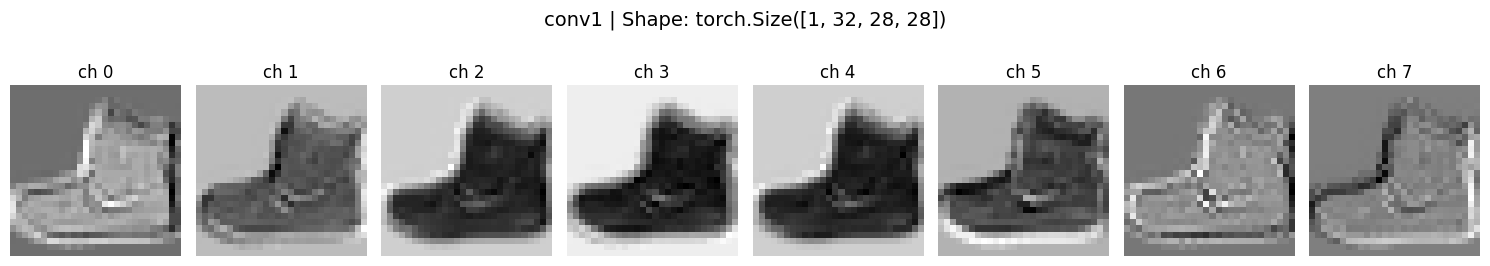

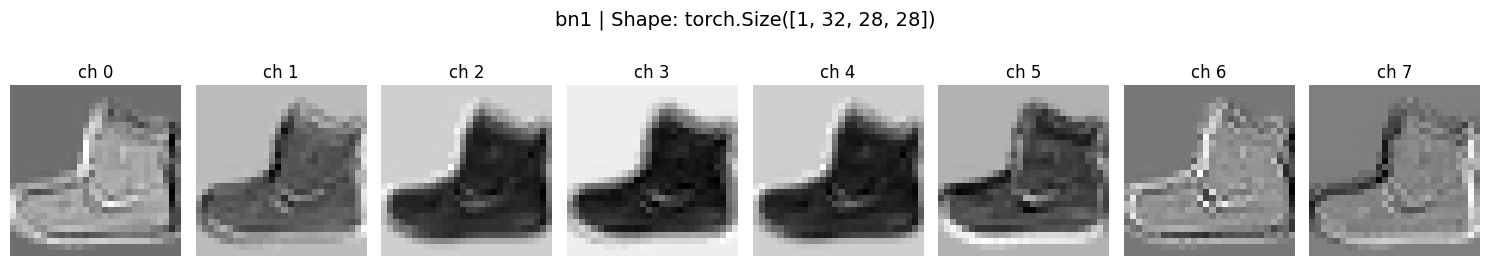

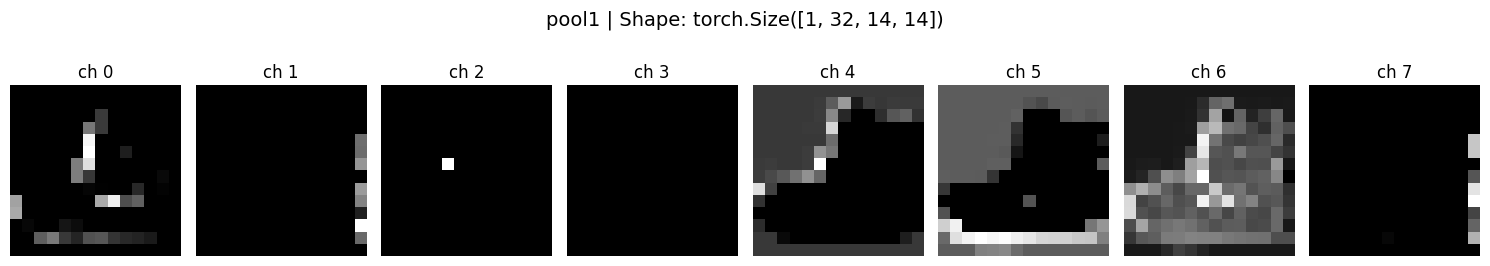

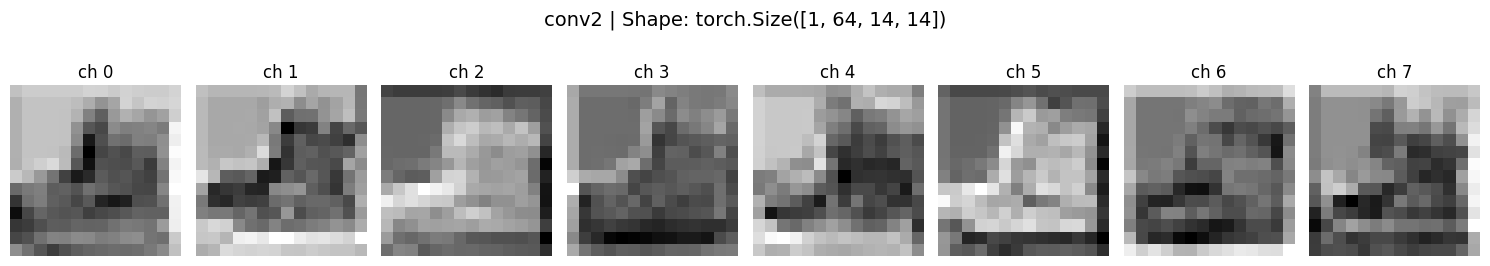

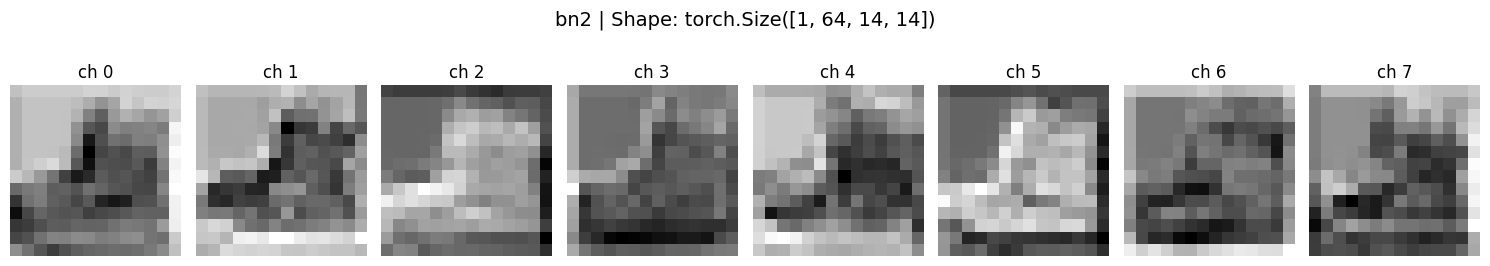

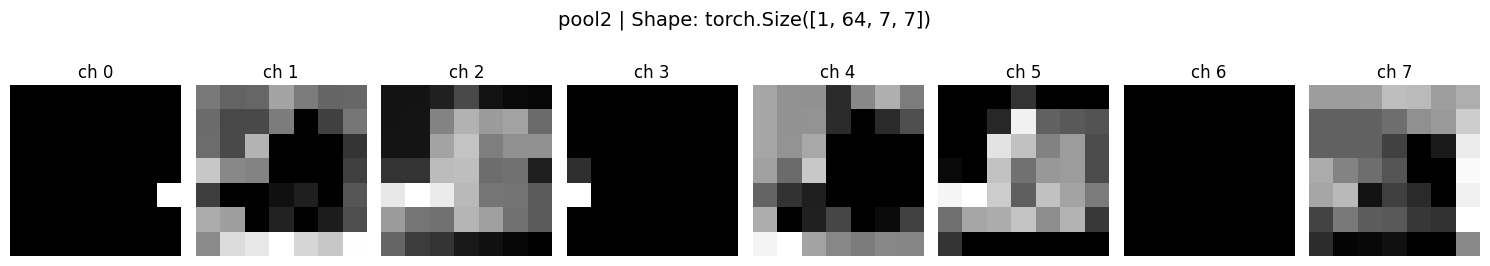

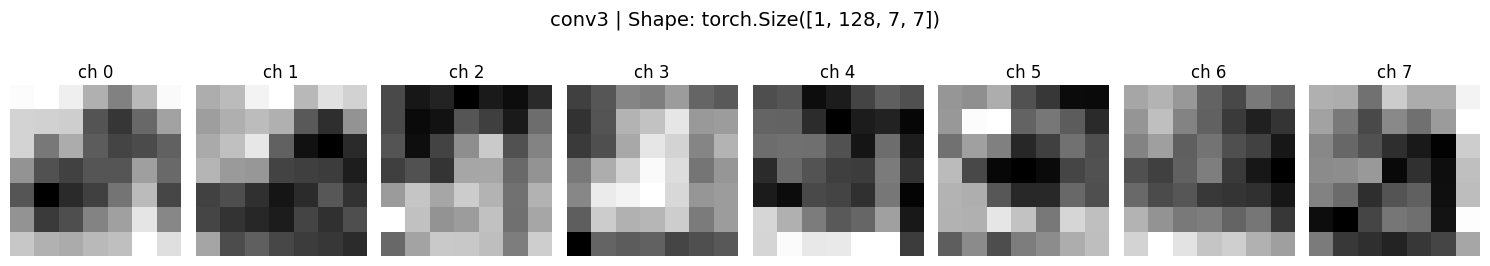

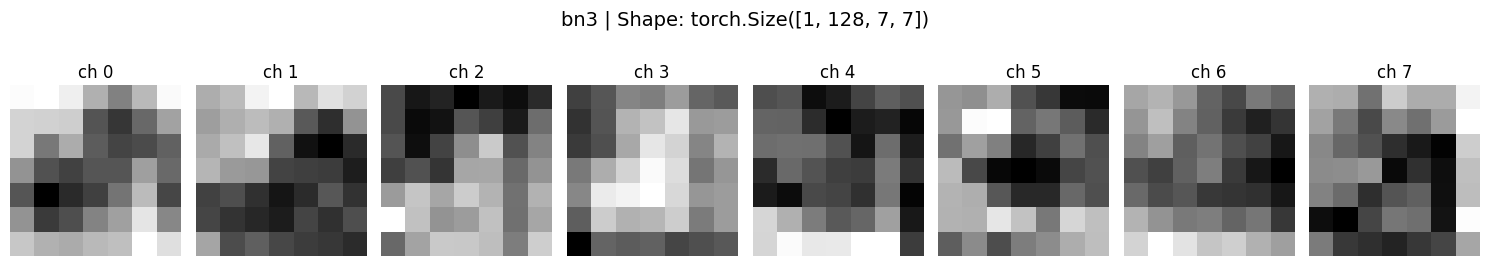

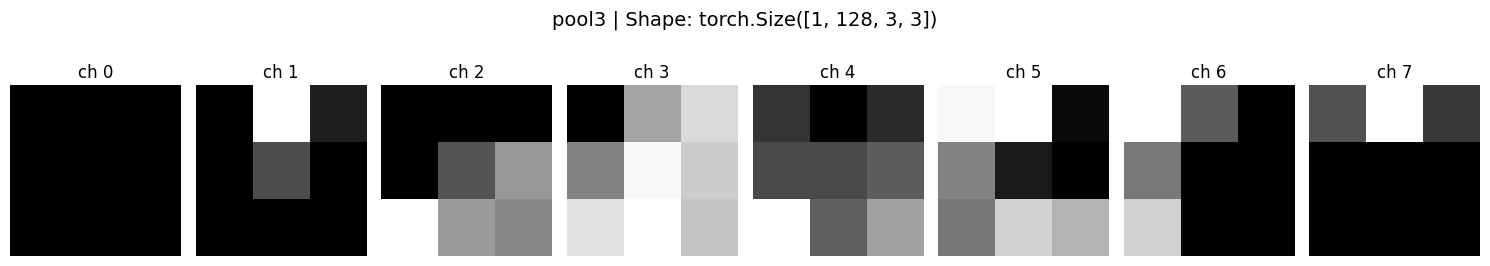

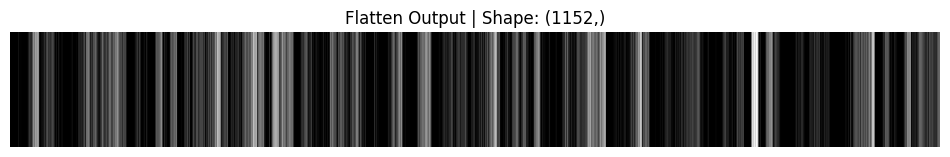

In [8]:
sample_img = X_train[0]  # shape [1, 28, 28]
visualize_feature_maps(model, sample_img, device)

## 3.Loss Function, Optimizer, Scheduler & Training Pipeline

This section outlines the core training pipeline used to train the FashionCNN model, including the loss function, optimizer, learning rate scheduler, and the early stopping mechanism.


###  Loss Function
- **CrossEntropyLoss** is used as the classification objective.
- It internally applies `LogSoftmax` + `NLLLoss`, making it suitable for multi-class classification tasks with logits output.


###  Optimizer
- We use the **Adam** optimizer, which combines momentum and adaptive learning rate strategies.
- Adam is generally a good default for deep learning models due to its fast convergence.


###  Learning Rate Scheduler
- We use `ReduceLROnPlateau` which reduces the learning rate when validation loss stops improving.
- This helps in escaping flat or suboptimal regions in the loss landscape.

### Early Stopping
- Early stopping monitors the validation loss and stops training when no improvement is observed for a fixed number of epochs (`patience`).
- Helps prevent overfitting and saves training time.


###  Training Loop Summary

```text
for each epoch:
    → train_one_epoch:
        - iterate through train_loader
        - update weights using loss.backward() + optimizer.step()
    → evaluate:
        - compute val_loss and val_acc
    → scheduler.step(val_loss)
    → record learning rate
    → check and save best model
    → apply early stopping


In [9]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)


In [10]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    lr_history = [] 

    best_val_acc = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

        scheduler.step(val_loss)

        lr_history.append(optimizer.param_groups[0]['lr']) 
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            print(f"Save new best models and verify accuracy: {val_acc:.4f}")
            torch.save(model.state_dict(), 'results/best_fashion_mnist_model.pth')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stop triggered at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_weights)
    return model, history,lr_history


Epoch 1/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.4966, Train Acc: 0.8178
Val Loss: 0.3489, Val Acc: 0.8725
Save new best models and verify accuracy: 0.8725
Epoch 2/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3343, Train Acc: 0.8785
Val Loss: 0.2952, Val Acc: 0.8935
Save new best models and verify accuracy: 0.8935
Epoch 3/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2958, Train Acc: 0.8913
Val Loss: 0.2698, Val Acc: 0.9031
Save new best models and verify accuracy: 0.9031
Epoch 4/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2715, Train Acc: 0.9000
Val Loss: 0.2543, Val Acc: 0.9100
Save new best models and verify accuracy: 0.9100
Epoch 5/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2582, Train Acc: 0.9048
Val Loss: 0.2665, Val Acc: 0.9001
Epoch 6/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2415, Train Acc: 0.9106
Val Loss: 0.2414, Val Acc: 0.9101
Save new best models and verify accuracy: 0.9101
Epoch 7/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2350, Train Acc: 0.9126
Val Loss: 0.2362, Val Acc: 0.9126
Save new best models and verify accuracy: 0.9126
Epoch 8/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2232, Train Acc: 0.9165
Val Loss: 0.2221, Val Acc: 0.9189
Save new best models and verify accuracy: 0.9189
Epoch 9/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2172, Train Acc: 0.9203
Val Loss: 0.2284, Val Acc: 0.9162
Epoch 10/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2087, Train Acc: 0.9218
Val Loss: 0.2171, Val Acc: 0.9226
Save new best models and verify accuracy: 0.9226
Epoch 11/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2049, Train Acc: 0.9233
Val Loss: 0.2231, Val Acc: 0.9204
Epoch 12/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1984, Train Acc: 0.9258
Val Loss: 0.2155, Val Acc: 0.9243
Save new best models and verify accuracy: 0.9243
Epoch 13/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1922, Train Acc: 0.9280
Val Loss: 0.2154, Val Acc: 0.9229
Epoch 14/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1866, Train Acc: 0.9305
Val Loss: 0.2141, Val Acc: 0.9228
Epoch 15/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1845, Train Acc: 0.9301
Val Loss: 0.2121, Val Acc: 0.9253
Save new best models and verify accuracy: 0.9253
Epoch 16/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1790, Train Acc: 0.9332
Val Loss: 0.2292, Val Acc: 0.9216
Epoch 17/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1763, Train Acc: 0.9328
Val Loss: 0.2133, Val Acc: 0.9241
Epoch 18/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1725, Train Acc: 0.9359
Val Loss: 0.2156, Val Acc: 0.9252
Epoch 19/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1541, Train Acc: 0.9417
Val Loss: 0.2001, Val Acc: 0.9302
Save new best models and verify accuracy: 0.9302
Epoch 20/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1487, Train Acc: 0.9443
Val Loss: 0.2053, Val Acc: 0.9296


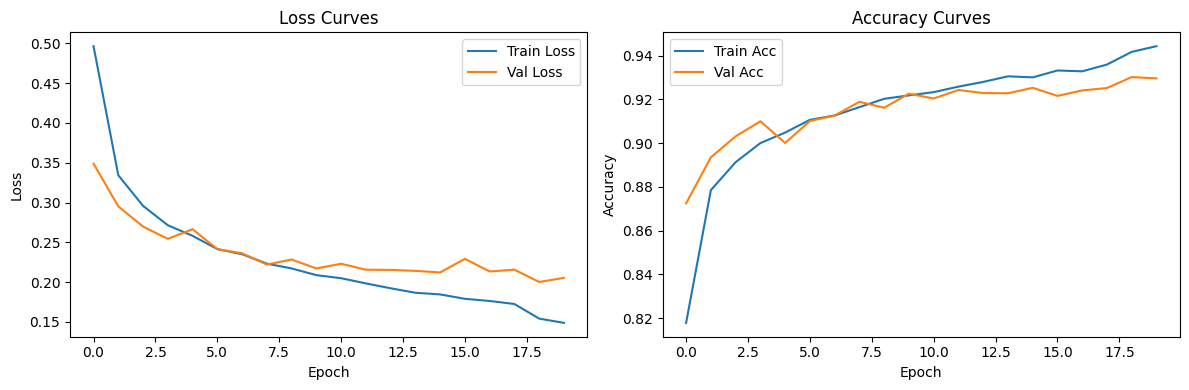

In [11]:
model, history, lr_history = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device
)


plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.savefig('results/training_curves.png')
plt.show()


###  Curve Analysis

🔹 Loss Curves (Left)
Training loss steadily decreases from ~0.50 to 0.15, indicating consistent learning.

Validation loss follows a similar trend, dropping to ~0.20 before plateauing, with no signs of overfitting (e.g., validation loss increasing while training loss decreases).

The gap between training and validation loss remains relatively narrow, further supporting stable generalization.

🔹 Accuracy Curves (Right)
Training accuracy improves continuously, reaching 94.4%.

Validation accuracy rises rapidly in the early epochs and stabilizes near 93.0%, with minor fluctuations.

The gap between training and validation accuracy remains small, indicating the model is not memorizing the training data, but learning meaningful patterns.


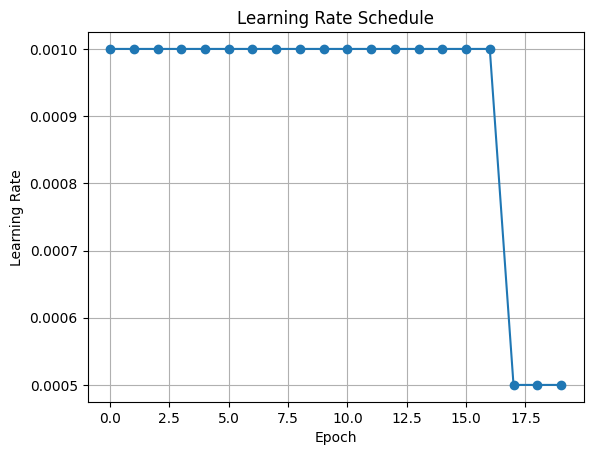

In [12]:
plt.figure()
plt.plot(lr_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.savefig('results/Learning_Rate_Schedule.png')
plt.show()


## Learning Rate Schedule Analysis

The plot shows the evolution of the learning rate across training epochs using `ReduceLROnPlateau`.

###  Observation

- **Initial LR:** 0.001 maintained from epoch 0 to 15.
- **Drop Triggered:** Around epoch 14, the validation loss plateaued.
- **New LR:** Dropped to 0.0005 (by factor of 0.5, as configured).

### Interpretation

- The scheduler worked as intended: reducing LR when improvement stagnated.
- This adjustment allowed the model to continue fine-tuning with a smaller step size, improving final accuracy.


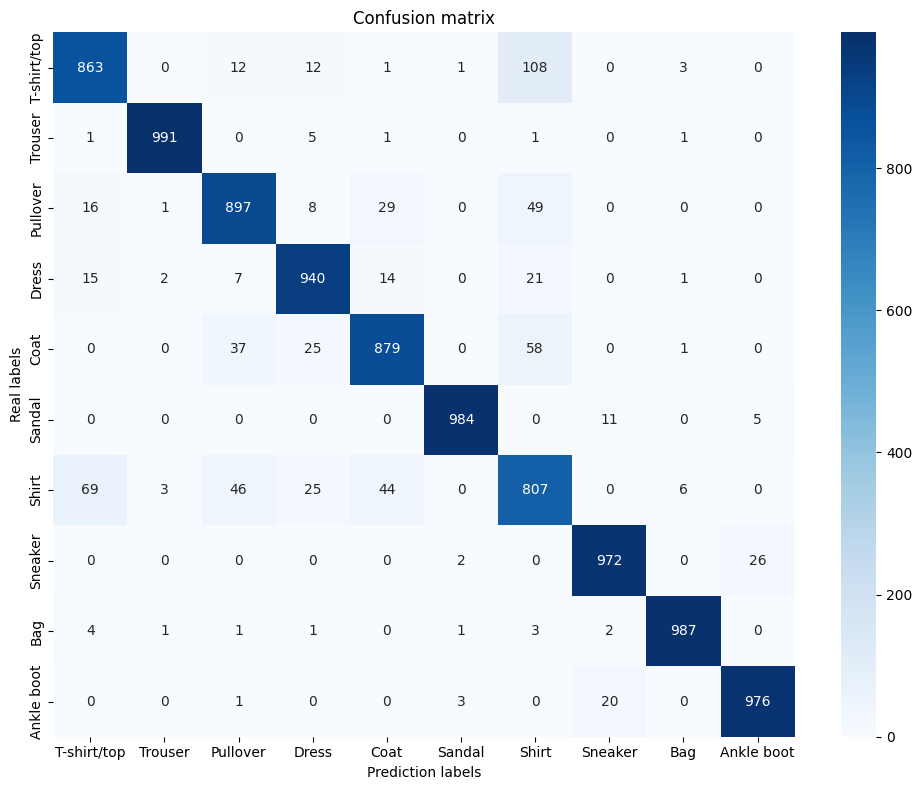

In [13]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediction labels')
plt.ylabel('Real labels')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png')
plt.show()


##  Confusion Matrix Analysis

The confusion matrix shows the distribution of predictions vs. actual labels for the 10 Fashion-MNIST classes.


###  Key Observations

- Most classes are classified accurately, especially:
  - **Trouser (Class 1):** 991 / 1000 correct
  - **Sneaker (Class 7):** 979 / 1000 correct
  - **Ankle boot (Class 9):** 974 / 1000 correct

- **Misclassifications are concentrated in:**
  - **T-shirt/top (Class 0)** → 108 misclassified as **Shirt (Class 6)**
  - **Pullover, Coat, Shirt** show mutual confusion, likely due to visual similarity.


###  Notable Confusion Pairs

| True Label | Common Confused With | Possible Reason            |
|------------|-----------------------|-----------------------------|
| T-shirt/top (0) | Shirt (6)           | Similar appearance          |
| Coat (4)        | Pullover (2), Shirt (6) | Overlapping shapes/textures |
| Shirt (6)       | All clothing types | Generally ambiguous         |




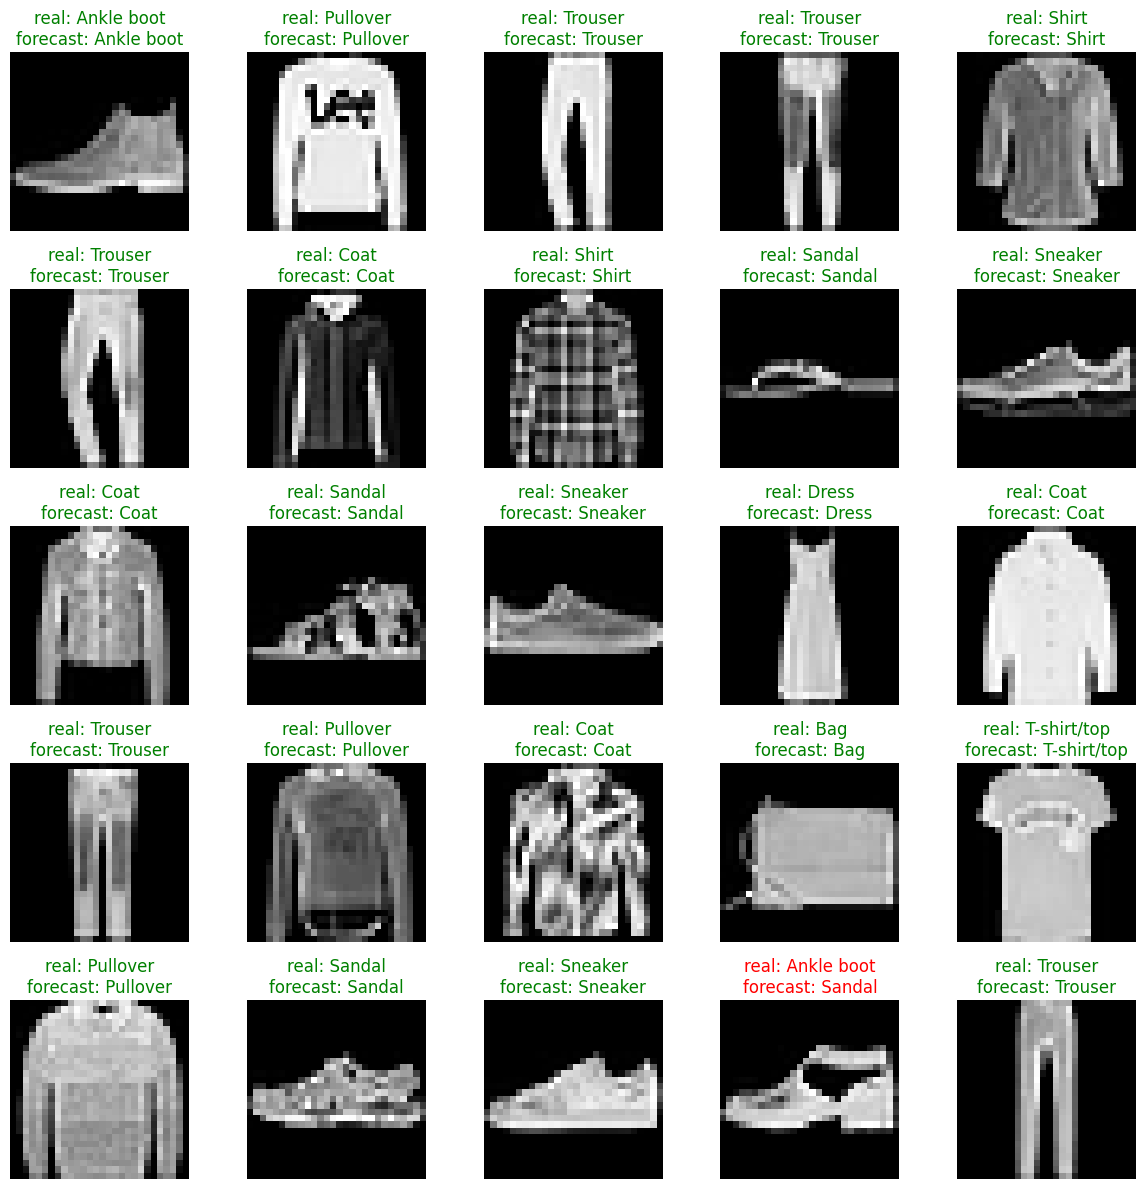

In [14]:
def visualize_predictions(model, test_loader, class_names, device, num_samples=25):
    model.eval()

    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples], labels[:num_samples]

    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"real: {class_names[labels[i]]}\nforecast: {class_names[preds[i]]}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/prediction_examples.png')
    plt.show()

visualize_predictions(model, test_loader, class_names, device)


In [15]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names
}, 'results/fashion_mnist_model_full.pth')

print("Model training and evaluation complete!")


Model training and evaluation complete!


## Custom CNN Model Summary

###  Objective

This project aims to design and evaluate a custom convolutional neural network (CNN) for image classification on the Fashion-MNIST dataset. The goal is to build a lightweight yet effective model using core deep learning components and analyze its learning behavior, accuracy, and generalization capability.



###  Model Overview

The CNN consists of stacked convolutional layers with batch normalization, pooling, and dropout, followed by a fully connected classifier. The training process is enhanced with data augmentation, learning rate scheduling, and early stopping to improve generalization.



###  Results
 
- **Training Accuracy:** 94.17%  
- **Validation Accuracy:** 93.02%  
- The model converged smoothly with no sign of overfitting.
- Learning rate scheduler successfully adjusted the training dynamics at plateau.
- Most classes are well separated, with minor confusion between visually similar categories (e.g., T-shirt vs. Shirt).



###  Conclusion & Future Work

The model demonstrates strong classification performance and generalization ability with minimal complexity. Future improvements may include:

- Exploring advanced learning rate strategies (e.g., CosineAnnealing)
- Applying interpretability techniques such as Grad-CAM
- Testing on real-world noisy or imbalanced datasets

This work confirms that well-designed custom CNNs can achieve competitive results without relying on heavyweight architectures.
